In [1]:
import os

import numpy as np
import pandas as pd

from math import ceil

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), f'output/vae_umaps')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
main = main[main['VAE9-VAE20'] != -1]  # removes -1s in VAE9 and VAE20 clusterings

In [3]:
# Map VAE20 clusters to contexts
VAE20_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable3.csv'))
cell_context = [VAE20_annot['Call'][VAE20_annot['Cluster'] == i].values[0] for i in main['VAE20']]
main['context'] = [i for i in cell_context]
            
# Map VAE9 clusters to cell states
VAE9_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable4.csv'))
cell_state = [VAE9_annot['Call'][VAE9_annot['Cluster'] == i].values[0] for i in main['VAE9']]
main['state'] = [i for i in cell_state]

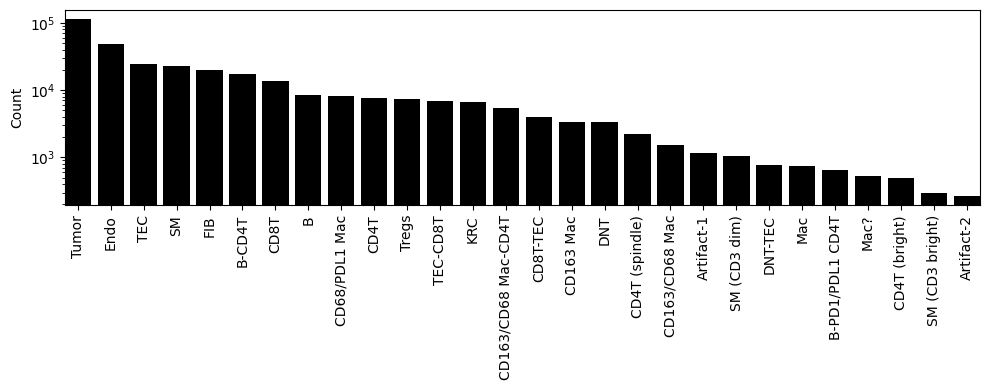

In [4]:
# Plot barchart of total cell state counts
bar = pd.DataFrame(main.groupby('state').size().sort_values(ascending=False))
bar.rename(columns={0: 'count'}, inplace=True)

context_abbrs = {
    'Transformed epithelial cells': 'Tumor', 'Endothelial cells': 'Endo',
    'Transitioning epithelial cells': 'TEC', 'Smooth muscle cells': 'SM',
    'Fibroblasts': 'FIB', 'B cells contacting CD4+ T cells': 'B-CD4T',
    'CD8+ T cells': 'CD8T', 'B cells': 'B',
    'CD68+ PD-L1+ macrophages': 'CD68/PDL1 Mac', 'CD4+ T cells': 'CD4T',
    'Tregs': 'Tregs',
    'Transformed epithelial cells contacting CD8+ T cells': 'TEC-CD8T',
    'Reactive keratinoctyes': 'KRC',
    'CD163+ CD68+ Macrophages contacting CD4+ T cells': 'CD163/CD68 Mac-CD4T',
    'CD8+ T cells contacting epithelial cells': 'CD8T-TEC',
    'CD163+ macrophages': 'CD163 Mac',
    'CD45RO+ double negative T cells': 'DNT',
    'CD4+ T cells (spindle morph.)': 'CD4T (spindle)',
    'CD163+ CD68+ macrophages': 'CD163/CD68 Mac',
    'Artifact (tissue tear/fold)': 'Artifact-1',
    'Double negative T cells/transformed epithelial cells': 'DNT-TEC',
    'Macrophages': 'Mac',
    'B cells contacting PD1+ PD-L1+ CD4+ T cells': 'B-PD1/PDL1 CD4T',
    'Macrophages?': 'Mac?', 'CD163+ Macrophages': 'CD163 Mac',
    'CD4+ bright T cells': 'CD4T (bright)',
    'Smooth muscle cells (CD3e bright)': 'SM (CD3 bright)',
    'Smooth muscle cells (CD3e dim)': 'SM (CD3 dim)',
    'Artifact (diffuse, non-specific Vim signal)': 'Artifact-2'
}

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x=[context_abbrs[i] for i in bar.index], height=bar['count'], color='k')
ax.tick_params(axis='x', which='major', labelsize=10, rotation=90)
ax.tick_params(axis='y', which='major', labelsize=10, rotation=0)
plt.ylabel('Count')
ax.set_yscale('log')
ax.margins(x=0)
plt.tight_layout()
plt.savefig(os.path.join(out, 'cell_states_counts.pdf'), bbox_inches='tight')
plt.show()
plt.close('all')

VAE9 (cell states) UMAP colored by VAE9-VAE20 (tuple) labels


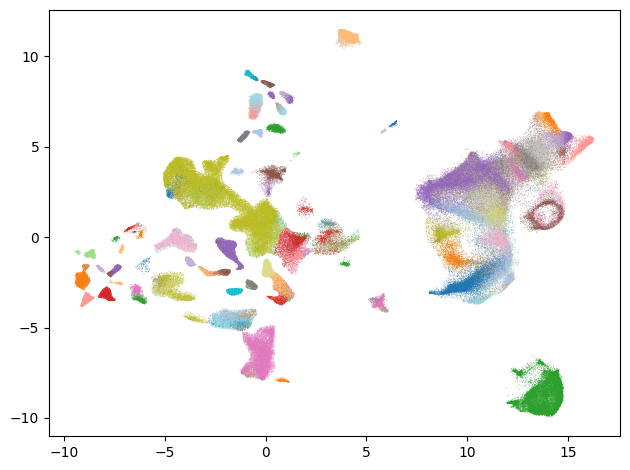

In [5]:
# VAE9 (cell states) UMAP colored by VAE9-VAE20 (tuple) labels
label_sizes = main.groupby('VAE9-VAE20').size()
selected_labels = label_sizes.index[label_sizes > 122]
umap_input = main[main['VAE9-VAE20'].isin(selected_labels)].copy()

custom_sort = [
    71, 102, 83, 105, 112, 151, 92, 136, 65, 68, 87, 82, 30, 144, 121, 139, 77,
    86, 63, 19, 113, 23, 88, 17, 133, 91, 50, 76, 90, 141, 59, 89, 3, 60, 47,
    135, 150, 42, 36, 56, 69, 115, 118, 8, 2, 81, 147, 15, 33, 34, 73, 58, 51,
    44, 13, 14, 84, 131, 140, 132, 20, 5, 22, 74, 100, 46, 96, 40, 1, 114, 25,
    130, 148, 21, 53, 6, 7, 11, 55, 39, 4, 12, 18, 101, 67, 57, 26, 27, 54, 85,
    110, 116, 70, 106, 98, 143, 29, 41, 32, 24, 128, 79, 99, 52, 117, 38, 62,
    122, 9, 97, 104, 61, 80, 64, 95, 124, 109, 111, 129, 75, 108, 149, 35, 66,
    28, 94, 107, 37, 103, 119, 31, 134, 146, 10, 45, 127, 0, 72, 120, 125, 142,
    78, 126, 145, 123, 137, 16, 43, 93, 49, 48, 138
]

num_colors = len(list(cm.tab20.colors))
num_clusters = len(umap_input['VAE9-VAE20'].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab20.colors) * palette_multiplier
colors = colors[0:num_clusters]
color_dict = dict(zip(custom_sort, colors))
cmap = [color_dict[i] for i in umap_input['VAE9-VAE20']]

plt.scatter(umap_input['VAE9_emb1'], umap_input['VAE9_emb2'], lw=0.0, c=cmap, s=0.2)
plt.tight_layout()
plt.savefig(os.path.join(out, 'UMAP9_by_VAE9-VAE20.png'), dpi=800, bbox_inches='tight')
print('VAE9 (cell states) UMAP colored by VAE9-VAE20 (tuple) labels')
plt.show()
plt.close('all')

# LOOP FOR IDENTIFYING INDIVIDUAL CLUSTERS IN UMAP EMBEDDING
# for label, color in color_dict.items():
#     print(label)
#     plt.scatter(umap['VAE9_emb1'], umap['VAE9_emb2'], lw=0.0, color='gainsboro', s=0.1)
#     plt.scatter(
#         umap['VAE9_emb1'][umap['VAE9-VAE20'] == label],
#         umap['VAE9_emb2'][umap['VAE9-VAE20'] == label],
#         lw=0.0, color=color, s=0.2
#     )
#     plt.show()

VAE20 (contexts) UMAP colored by VAE9-VAE20 (tuple) labels


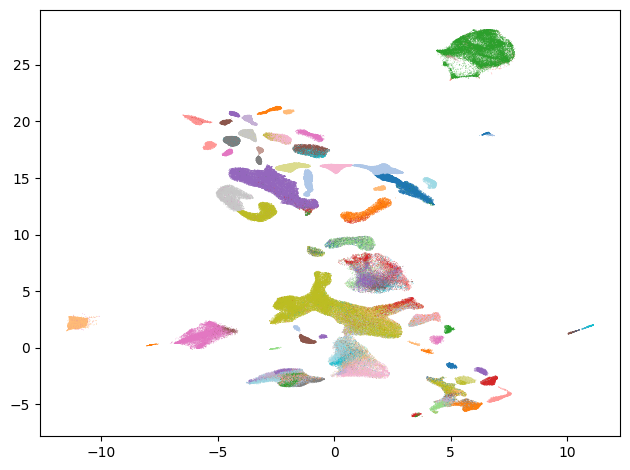

In [6]:
# VAE20 (contexts) UMAP colored by VAE9-VAE20 (tuple) labels
num_colors = len(list(cm.tab20.colors))
num_clusters = len(umap_input['VAE9-VAE20'].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab20.colors) * palette_multiplier
colors = colors[0:num_clusters]
color_dict = dict(zip(custom_sort, colors))
cmap = [color_dict[i] for i in umap_input['VAE9-VAE20']]

plt.scatter(umap_input['VAE20_emb1'], umap_input['VAE20_emb2'], lw=0.0, c=cmap, s=0.2)
plt.tight_layout()
plt.savefig(os.path.join(out, 'UMAP20_by_VAE9-VAE20.png'), dpi=800, bbox_inches='tight')
print('VAE20 (contexts) UMAP colored by VAE9-VAE20 (tuple) labels')
plt.show()
plt.close('all')

# LOOP FOR FINDING IDENTIFYING INDIVIDUAL CLUSTERS
# for label, color in color_dict.items():
#     print(
#         umap[['VAE9-VAE20', 'VAE_Tuples', 'state', 'context']][umap['VAE9-VAE20'] == label].iloc[0]
#     )
#     print()
#     plt.scatter(umap['VAE20_emb1'], umap['VAE20_emb2'], lw=0.0, color='gainsboro', s=0.1)
#     plt.scatter(
#         umap['VAE20_emb1'][umap['VAE9-VAE20'] == label],
#         umap['VAE20_emb2'][umap['VAE9-VAE20'] == label],
#         lw=0.0, color=color, s=0.5
#     )
#     plt.show()

VAE20 (contexts) UMAP colored by VAE9 (cell state) labels


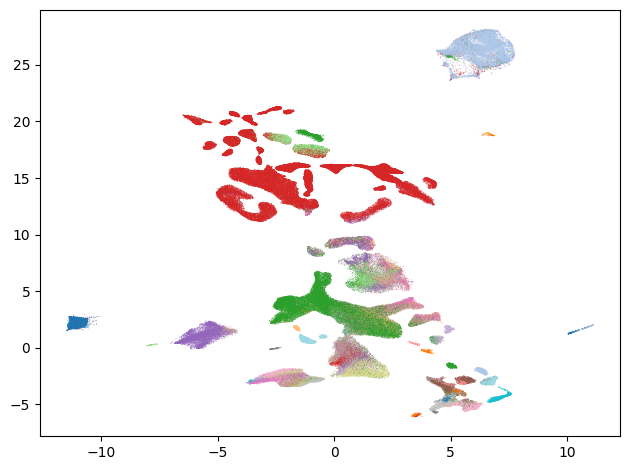

In [7]:
# VAE20 (contexts) UMAP colored by VAE9 (cell states) colors
label_sizes = main.groupby('VAE9-VAE20').size()
selected_labels = label_sizes.index[label_sizes > 122]
umap_input = main[main['VAE9-VAE20'].isin(selected_labels)].copy()

num_colors = len(list(cm.tab20.colors))
num_clusters = len(umap_input['VAE9'].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab20.colors) * palette_multiplier
colors = colors[0:num_clusters]
color_dict = dict(zip(sorted(umap_input['VAE9'].unique()), colors))
cmap = [color_dict[i] for i in umap_input['VAE9']]

plt.scatter(umap_input['VAE20_emb1'], umap_input['VAE20_emb2'], lw=0.0, c=cmap, s=0.2)
plt.tight_layout()
plt.savefig(os.path.join(out, 'UMAP20_by_VAE9.png'), dpi=800, bbox_inches='tight')
print('VAE20 (contexts) UMAP colored by VAE9 (cell state) labels')
plt.show()
plt.close('all')

# LOOP FOR FINDING IDENTIFYING INDIVIDUAL CLUSTERS
# for label, color in color_dict.items():
#     print(label)
#     plt.scatter(umap['VAE20_emb1'], umap['VAE20_emb2'], lw=0.0, color='gainsboro', s=0.1)
#     plt.scatter(
#         umap['VAE20_emb1'][umap['VAE9'] == label],
#         umap['VAE20_emb2'][umap['VAE9'] == label],
#         lw=0.0, color=color, s=0.2
#     )
#     plt.show()